In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pre Processing

In [ ]:
df_rating=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/rating.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,02-04-2005 23:53
1,1,29,3.5,02-04-2005 23:31
2,1,32,3.5,02-04-2005 23:33
3,1,47,3.5,02-04-2005 23:32
4,1,50,3.5,02-04-2005 23:29


In [ ]:
df_movie=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/movie.csv')
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_gscores=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/genome_scores.csv')
df_gscores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [ ]:
df_gtag=pd.read_csv('https://raw.githubusercontent.com/maheshv18/ContentBasedMovieRecommender/main/genome_tags.csv')
df_gtag.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [ ]:
df_movie.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [ ]:
print('The total number of movies in the dataset : {}'.format(len(df_movie['movieId'].unique())))

The total number of movies in the dataset : 27278


In [ ]:
df_tmp=df_movie[df_movie.duplicated(subset = 'title', keep = False)]
list1=[]
list2=[]
for j in range(32):
    x=0
    for i in range(31):
        if df_tmp.iloc[j,1]== df_tmp.iloc[i+1,1]:
            if df_tmp.iloc[j,2]== df_tmp.iloc[i+1,2]:
                x+=1
                if x>1:
                    list1.append(df_tmp.iloc[j,1])
                else:
                    list2.append(df_tmp.iloc[j,1])
                    
print('List of duplicate movies with same genres {}'.format(list(set(list1))))
print('')
print('List of dullicate movies with different genres {}'.format(list(set(list2)-set(list1))))


List of duplicate movies with same genres ['Darling (2007)', 'Johnny Express (2014)', 'Girl, The (2012)', 'Clear History (2013)', 'Offside (2006)', 'Beneath (2013)']

List of dullicate movies with different genres ['Emma (1996)', 'Blackout (2007)', 'War of the Worlds (2005)', 'Men with Guns (1997)', 'Chaos (2005)', '20,000 Leagues Under the Sea (1997)', 'Paradise (2013)', 'Casanova (2005)', 'Hamlet (2000)', 'Aladdin (1992)']


In [ ]:
df_movie.drop_duplicates(subset='title', inplace = True, keep= 'first')

In [ ]:
df_movie[df_movie.duplicated(subset = 'title', keep = False)]

,movieId,title,genres


In [ ]:
print('The number of movies which are rated by users : {}'.format(len(df_rating['movieId'].unique())))

The number of movies which are rated by users : 10372


In [ ]:
d=df_rating.groupby('movieId').mean()['rating']
df=pd.DataFrame(d, columns=['rating']).reset_index()
df.head()

,movieId,rating
0,1,4.000000
1,2,3.284000
2,3,3.193103
3,4,3.038462
4,5,3.144295


In [ ]:
count_ratings = pd.DataFrame(df_rating.groupby('rating').count())
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)
count_ratings['perc_total']

rating
0.5     1.5
1.0     3.7
1.5     1.4
2.0     7.3
2.5     4.3
3.0    21.8
3.5    10.7
4.0    27.5
4.5     7.5
5.0    14.2
Name: perc_total, dtype: float64

In [ ]:
gc = pd.DataFrame(df_movie.groupby('genres')['genres'].count())
gc.rename(columns = {'genres':'Count'}, inplace = True)
gc

,Count
genres,
(no genres listed),246
Action,178
Action|Adventure,86
Action|Adventure|Animation,18
Action|Adventure|Animation|Children,8
...,...
Thriller|War,9
Thriller|Western,2
War,32


In [ ]:
ratings_pivot = df_rating.pivot(index='movieId',columns='userId',values='rating')
ratings_pivot.fillna(0,inplace=True)
ratings_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,4.5,4.0,4.0,4.5,0.0,3.0,0.0,0.0,5.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,...,3.0,0.0,3.5,4.0,0.0,5.0,0.0,0.0,0.0,4.0,5.0,3.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [ ]:
len(df_rating['userId'].unique())

1596

In [ ]:
df2=pd.merge(df_movie, df, on='movieId', how='left' )
df2['Year']=df2['title'].str.extract('.*\((.*)\).*')
df2.head()

,movieId,title,genres,rating,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.000000,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.284000,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,3.193103,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.038462,1995
4,5,Father of the Bride Part II (1995),Comedy,3.144295,1995


In [ ]:
df2['Year'].replace(['Das Millionenspiel','Bicicleta, cullera, poma','2007-','2009– ', '1975-1979', '1983)'], value=[np.nan, np.nan, '2007', '2009', '1975', '1983' ], inplace=True)

In [ ]:
year=df2['Year'].dropna().astype('int64', copy= True).sort_values().unique().tolist()
year=list(map(str, year))

In [ ]:
df7=df2[['Year', 'movieId']].groupby('Year').count()
df7.rename(mapper={'movieId': 'movies/year'}, inplace= True, axis=1)
df7.head()

,movies/year
Year,
1891,1
1893,1
1894,2
1895,2
1896,2


In [ ]:
print('# Movies for which rating is not available:{}'.format(df2['rating'].isnull().sum()))

# Movies for which rating is not available:16893


In [ ]:
print('The total number of unique movies(title) in the dataset : {}'.format(len(df_movie['title'].unique())))

The total number of unique movies(title) in the dataset : 27262


In [ ]:
df_movie.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

# Visualization

(array([ 3530.,  8556.,  3254., 16930., 10049., 50408., 24754., 63493.,
        17337., 32835.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

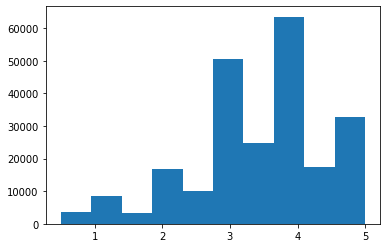

In [ ]:
plt.hist(df_rating['rating'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


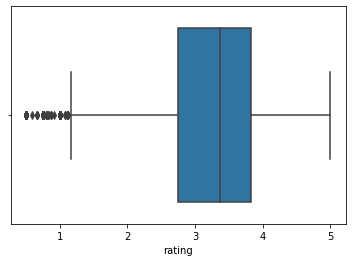

In [ ]:
sns.boxplot(df['rating'], orient='v')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


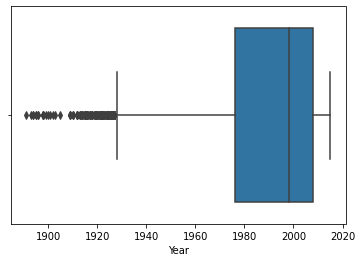

In [ ]:
df2['Year'].replace(['Das Millionenspiel','Bicicleta, cullera, poma','2007-','2009– ', '1975-1979', '1983)'], value=[np.nan, np.nan, '2007', '2009', '1975', '1983' ], inplace=True)
sns.boxplot(df2['Year'].dropna().astype('int64'), orient='v')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


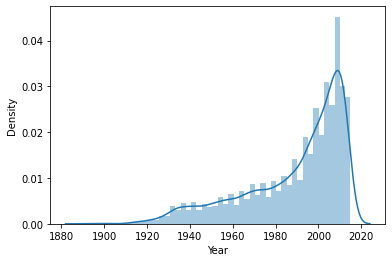

In [ ]:
sns.distplot(df2['Year'].dropna().astype('int64'))

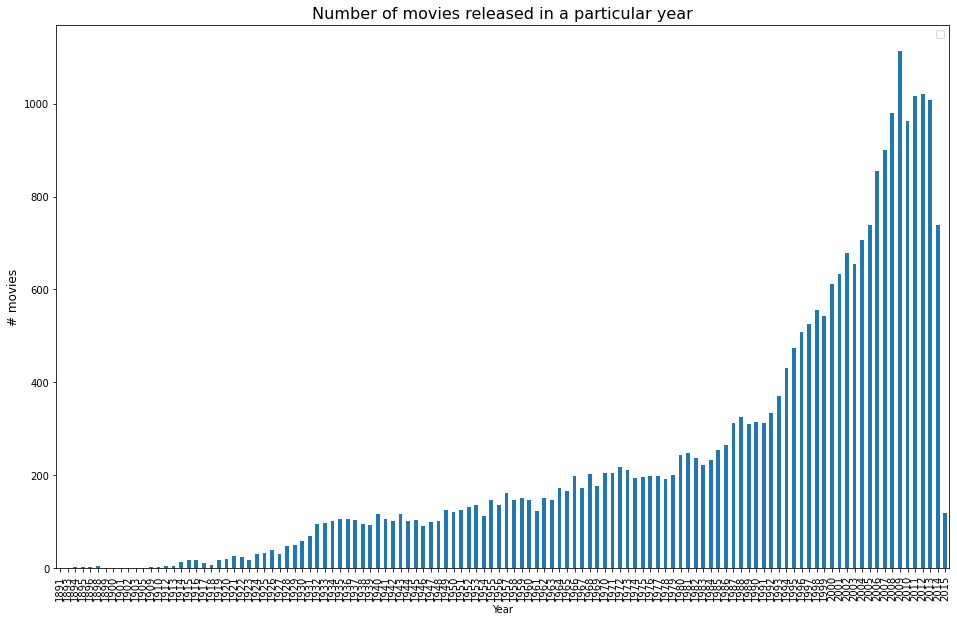

In [ ]:
df7.plot.bar(figsize=(16,10))
plt.ylabel('# movies', fontsize=12)
plt.title('Number of movies released in a particular year', fontsize=16)
plt.legend('')

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
el = df_rating["rating"].value_counts().reset_index()
el.columns = ["rating", "percent"]
el["percent"] /= df_rating.shape[0]

fig = px.pie(el,
            names="rating",
            values="percent",
            title = "Rating Percent",
            width = 800,
            height=500
            )
fig.show()

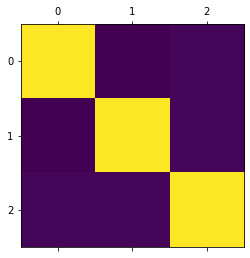

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(df_rating.corr())
plt.show()

In [ ]:
genres_lis=['Romance', 'Fantasy', 'Animation', 'Action', 'Film-Noir', 'Adventure', 'Horror', 'IMAX', 'Musical', 'War', 'Drama', 'Comedy', 'Crime', 'Mystery', '(no genres listed)', 'Documentary', 'Western', 'Thriller', 'Children', 'Sci-Fi']

In [ ]:
df3=df_gscores[df_gscores.groupby('movieId')['relevance'].transform(max)==df_gscores['relevance']]
df3=df3.drop_duplicates(subset='movieId')
df4=pd.merge(df3, df_gtag, how='left', on='tagId')
df5=pd.merge(df2, df4, how='left', on='movieId')
df5.rename(mapper={'tag':'High_relevance_tag', 'tagId':'High_relevance_tagId'}, axis=1, inplace=True)
for i in range(len(genres_lis)):
    df5[genres_lis[i]]=df5['genres'].str.contains(genres_lis[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



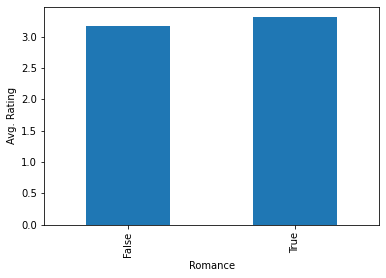

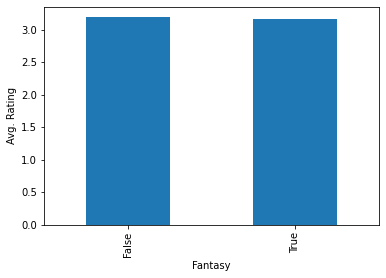

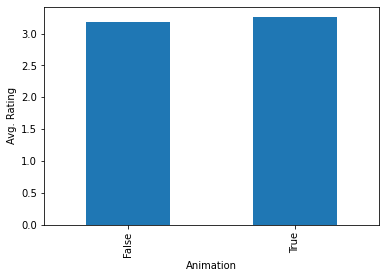

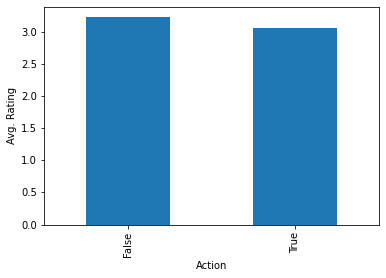

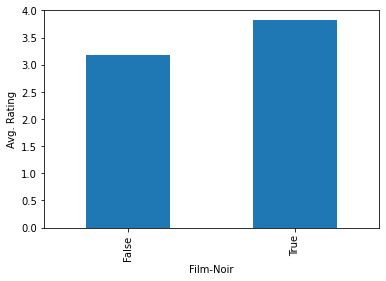

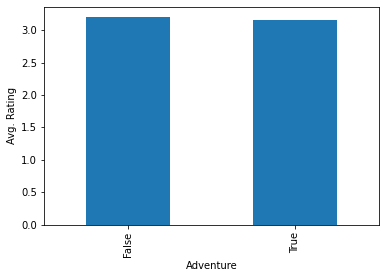

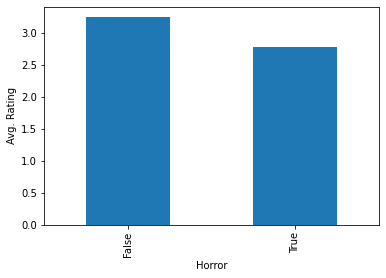

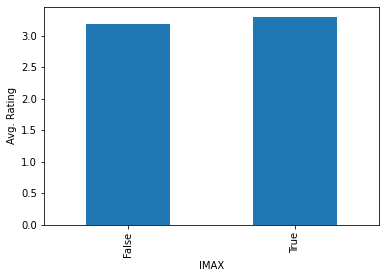

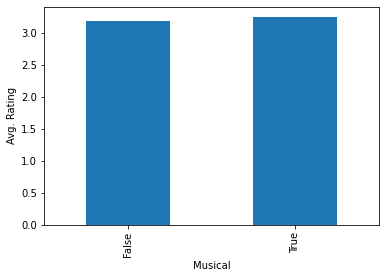

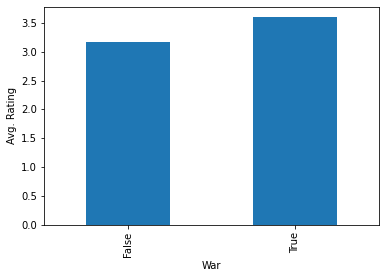

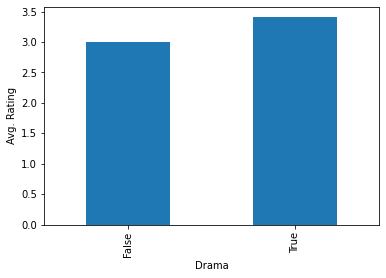

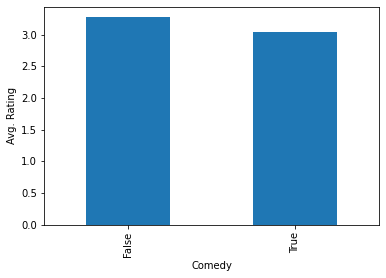

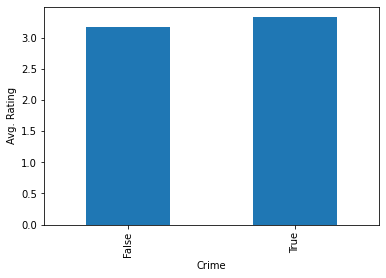

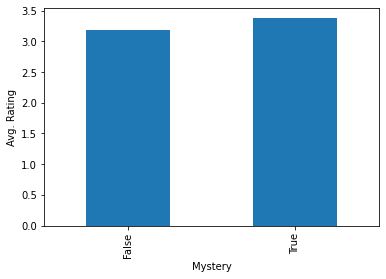

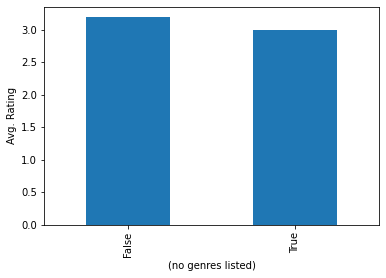

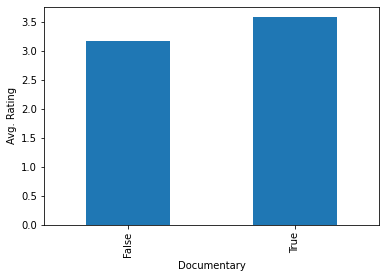

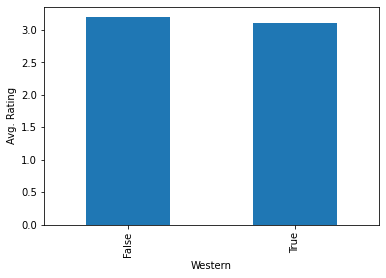

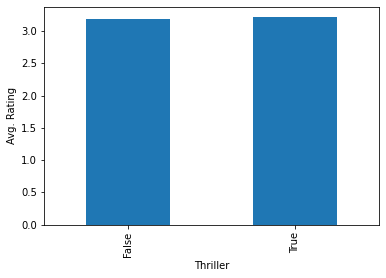

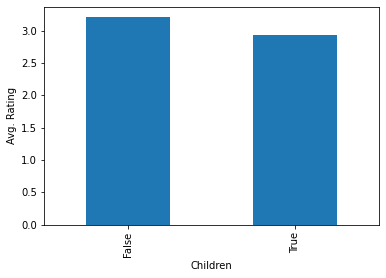

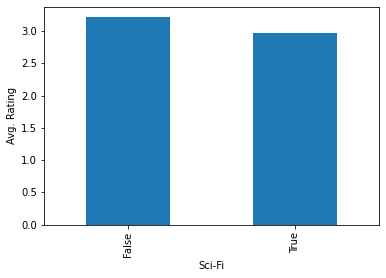

In [ ]:
for genre in genres_lis:
    df5.groupby(genre)['rating'].mean().plot.bar()
    plt.ylabel('Avg. Rating')
    plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Avg. Rating W.R.T Genres')

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

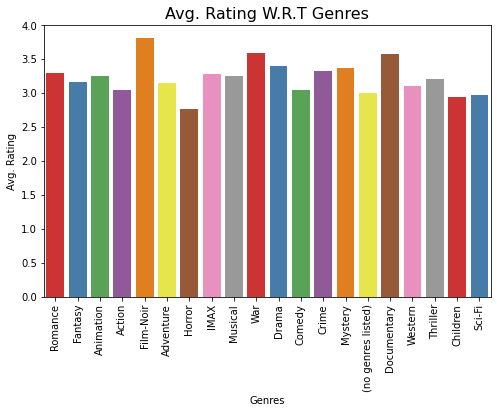

In [ ]:
avg_rating=[]
for genre in genres_lis:
    avg_rating.append(df2[df2['genres'].str.contains(genre)]['rating'].mean())
    plt.figure(figsize=(8,5))
sns.barplot(genres_lis, avg_rating,palette='Set1')
plt.xticks(rotation='vertical')
plt.ylabel('Avg. Rating')
plt.xlabel('Genres')
plt.title('Avg. Rating W.R.T Genres', fontsize=16)

Text(0.5, 1.0, 'Percentage of movies which are highly rated(>=4) respect to Year')

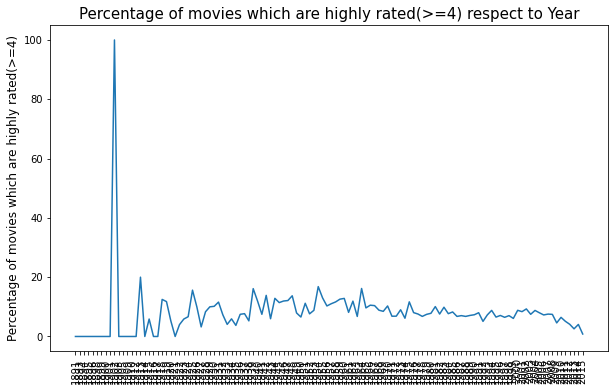

In [ ]:
rating_lis=[]
for i in range(len(year)):
    le=len(df2[(df2['rating']>=4) & (df2['Year']== year[i])])
    if le>0:

        rating_lis.append((le/(df7.loc[year[i]]['movies/year']))*100)
    else:
        rating_lis.append(0) 
        
rating_lis[:5]
plt.figure(figsize=(10,6))
plt.plot(year,rating_lis)
plt.xticks(rotation='vertical')
plt.ylabel("Percentage of movies which are highly rated(>=4)", fontsize=12)
plt.title('Percentage of movies which are highly rated(>=4) respect to Year', fontsize=15)

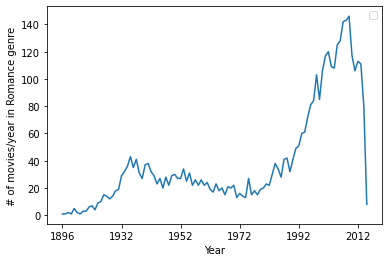

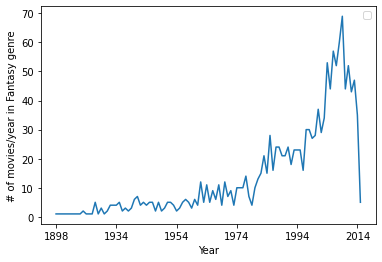

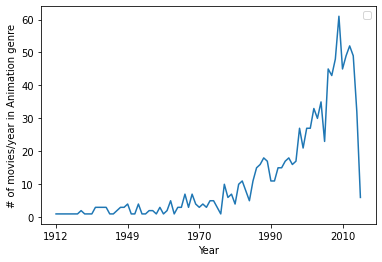

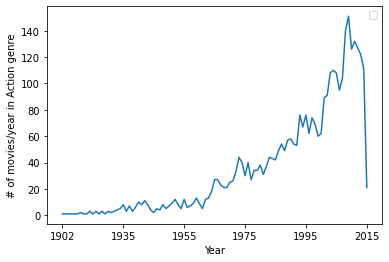

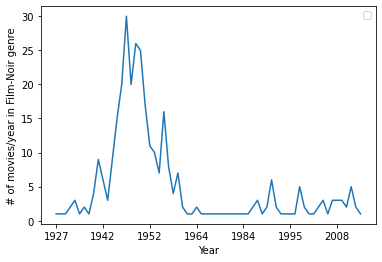

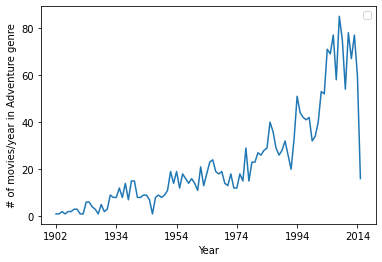

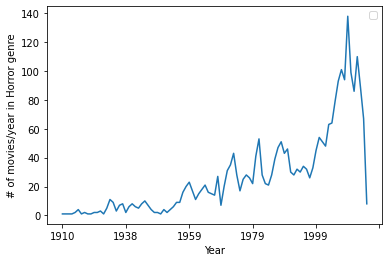

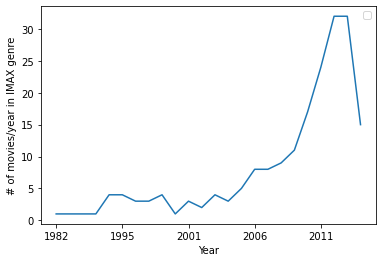

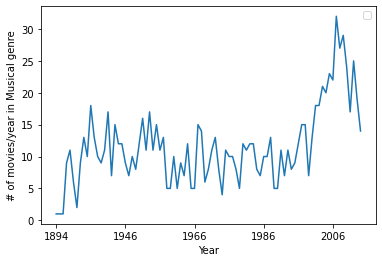

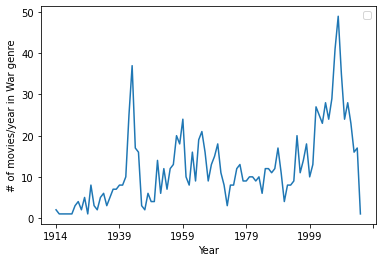

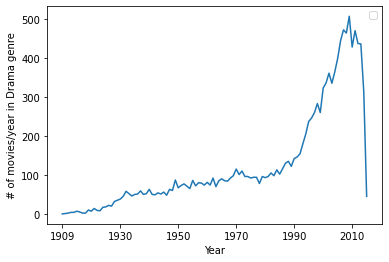

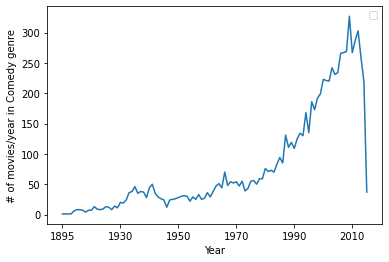

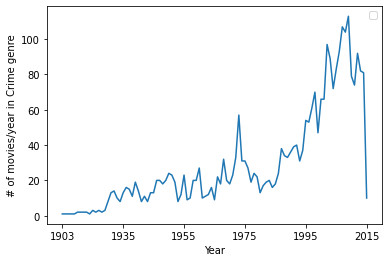

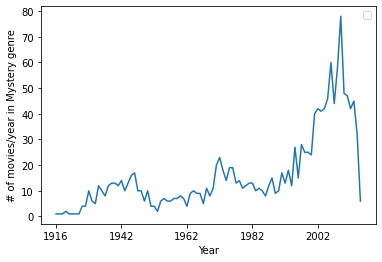

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



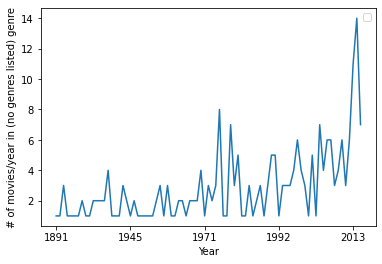

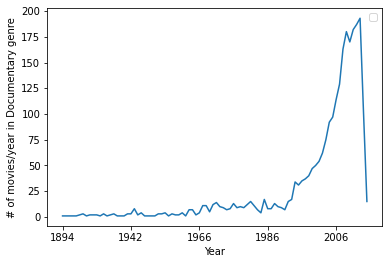

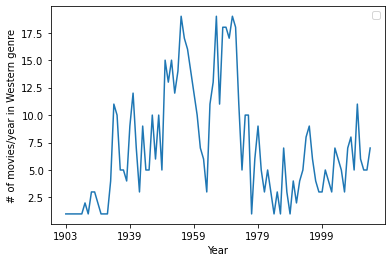

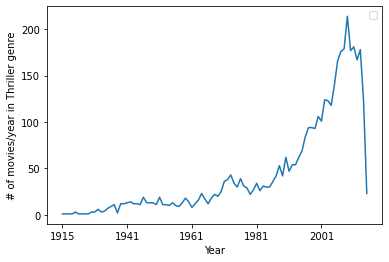

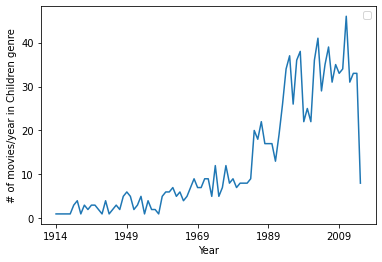

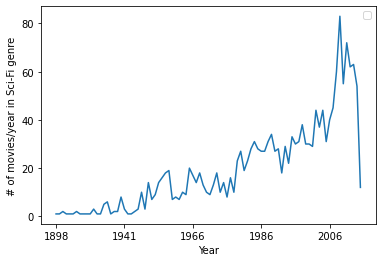

In [ ]:
for genre in genres_lis:
    df2[df2['genres'].str.contains(genre)][['Year','movieId']].groupby('Year').count().reset_index().sort_values(by='Year').plot('Year', 'movieId')
    plt.legend('')
    plt.ylabel('# of movies/year in {} genre'.format(genre))
    plt.show()

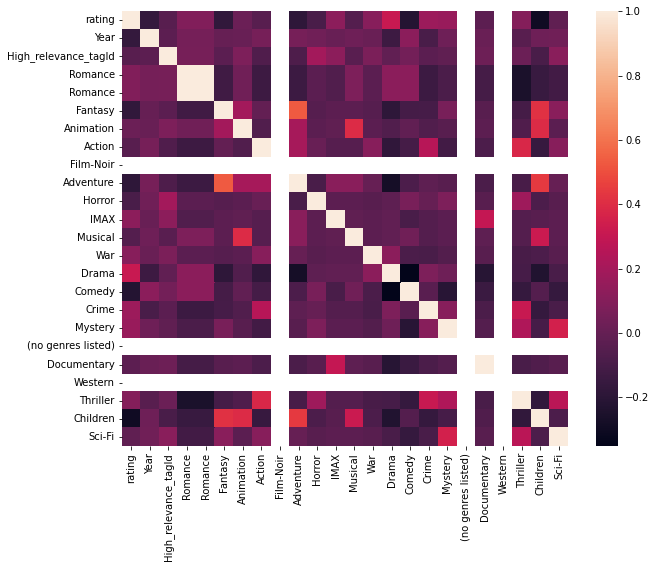

In [ ]:
df5=df5.dropna()
df5['Year']=df5['Year'].astype('int64')
plt.figure(figsize = (10,8))
sns.heatmap(df5[['rating', 'Year', 'High_relevance_tagId','Romance', 'Romance', 'Fantasy', 'Animation',
       'Action', 'Film-Noir', 'Adventure', 'Horror', 'IMAX', 'Musical', 'War',
       'Drama', 'Comedy', 'Crime', 'Mystery', '(no genres listed)',
       'Documentary', 'Western', 'Thriller', 'Children', 'Sci-Fi']].corr(), annot=False)

# Recommender

In [ ]:
df=df_movie.merge(df_rating,"left",on="movieId")
rating_count=pd.DataFrame(df["title"].value_counts())
exc_movies=rating_count[rating_count["title"]<=8000].index
common_movies=df[df["title"].isin(exc_movies)]
user_movie_df=common_movies.pivot_table(index="userId",columns="title",values="rating")

In [ ]:
def item_based_recommender(movie_name,user_movie_df):
    movie_name_df=user_movie_df[movie_name]
    return list(user_movie_df.corrwith(movie_name_df).sort_values(ascending=False).head(6).index)

In [ ]:
random_user = 1001

In [ ]:
movie_code=df_rating[df_rating["userId"]==random_user].sort_values("timestamp", ascending=False).\
sort_values("rating", ascending=False).iloc[0,1]
movie_code

1213

In [ ]:
movie_name=""
for i in (df_movie[df_movie["movieId"]==movie_code]["title"]):
    movie_name+=i

movie_name

'Goodfellas (1990)'

In [ ]:
item_based_recommender(movie_name,user_movie_df)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide



['Safe Passage (1994)',
 'Rio Grande (1950)',
 "I'm a Cyborg, But That's OK (Saibogujiman kwenchana) (2006)",
 'Ultimate Gift, The (2006)',
 'Wind (1992)',
 'At Play in the Fields of the Lord (1991)']